# Data cleaning

In [1]:
import sys
sys.path.append('utils/')
import pandas as pd
import numpy as np
from utils import Metrica_IO as mio
from utils import Metrica_Viz as mviz
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

Import the datasets:

In [8]:
DATA_DIR = 'data/'
game_id = 2
home_xy, away_xy, events = mio.read_match_data(DATA_DIR, game_id)

Reading team: home
Reading team: away


Consider the dataset *events*. The condition `Type`=*SET PIECE* identifies a moment in which the game restart after a stop (kick-in after the ball exits from the pitch, or the kick-off after a goal). Thus, we seek to remove all the frames corresponding to "dead" moments preceding a set piece.

In [10]:
# Indexes of the rows where the set pieces start
index_list = events.loc[events['Type'] == 'SET PIECE'].index.to_list()
# We need of course the indexes of the events preceding the set pieces!
index_list.extend([index_list[i] -1 for i in range(1, len(index_list))])
sorted_index_list = sorted(index_list)[1:]

We now define an empty list that will store the frames to be discarded:

In [11]:
frames_to_remove = []
for i in sorted_index_list[::2]:
    frames_to_remove.extend(list(range(events['End Frame'][i], events['Start Frame'][i+1])))
print("Frames to remove (dead moments before SET PIECES)-->",len(frames_to_remove))

Frames to remove (dead moments before SET PIECES)--> 42074


Now we discard the frames associated to dead moments between an infraction and the moment in which the ref extracts the card

*Note*: the reasoning is exactly the same done for the set pieces!

In [12]:
card_list = events.loc[events['Type'] == 'CARD'].index.to_list()
card_list.extend([card_list[i] -1 for i in range(0, len(card_list))])
sorted_card_list = sorted(card_list)[:]

In [13]:
for i in sorted_card_list[::2]:
    frames_to_remove.extend(list(range(events['End Frame'][i], events['Start Frame'][i+1])))
print("Frames to remove (dead moments before SET PIECES and before CARDS)-->",len(frames_to_remove))

Frames to remove (dead moments before SET PIECES and before CARDS)--> 44508


Trick to remove potential duplicates:

In [14]:
frames_to_remove = list(set(frames_to_remove))
len(frames_to_remove)

44508

Now we can finally remove the frames associated to the set pieces and the dead moments from the coordinates datasets:

In [15]:
home_xy=home_xy.drop(frames_to_remove)
away_xy=away_xy.drop(frames_to_remove)

We also remove the frames preceding the effective beginning of the match:

In [16]:
# Start from the kick off
home_xy=home_xy[50:]
away_xy=away_xy[50:]

Now that we cleaned up the frames, we can convert the coordinates to the same reference system of the pitch:

In [17]:
home_xy=mio.to_metric_coordinates(home_xy)
away_xy=mio.to_metric_coordinates(away_xy)
events=mio.to_metric_coordinates(events)

# Convex Hulls

For each dataframe we compute the area of the convex hull identified by the players of each team

In [18]:
hulls_df=pd.DataFrame(columns=['Period','Frame','Time [s]','HomeHull','AwayHull'])
for frame in trange(home_xy.shape[0],desc="Convex Hulls estimation:"):
    time=home_xy.iloc[frame,:]['Time [s]']
    period=home_xy.iloc[frame,:]['Period']
    home_data=home_xy.iloc[frame,:]
    away_data=away_xy.iloc[frame,:]
    home_data=home_data.dropna()
    away_data=away_data.dropna()
    ball=np.array(home_data[-2:])
    home_data= home_data[4:-2] #exclude both the goalkeeper and the ball
    away_data= away_data[4:-2] #exclude both the goalkeeper and the ball
    #--------------------------------------------------------------------
    # divide x and y
    home_data_x=home_data[home_data.index.str.contains('_x')]
    home_data_y=home_data[home_data.index.str.contains('_y')]
    away_data_x=away_data[away_data.index.str.contains('_x')]
    away_data_y=away_data[away_data.index.str.contains('_y')]
    #--------------------------------------------------------------------
    # Coordinates
    home_pts= np.array([[x,y] for x,y in zip(home_data_x,home_data_y)])
    away_pts= np.array([[x,y] for x,y in zip(away_data_x,away_data_y)])
    # Compute the convex hulls
    home_hull=ConvexHull(home_pts)
    away_hull=ConvexHull(away_pts)
    # Compute the area of the convex hulls
    home_area=home_hull.volume
    away_area=away_hull.volume
    
    hulls_df.loc[frame]=[period,frame,time,home_area,away_area]
    
#hulls_df.to_csv('data/hulls_df_matchday2.csv',index=False)

Convex Hulls estimation:: 100%|██████████| 96598/96598 [02:00<00:00, 804.90it/s] 


# Data analysis

As an example, we can plot the convex hulls of the players of the first team in the first frame:

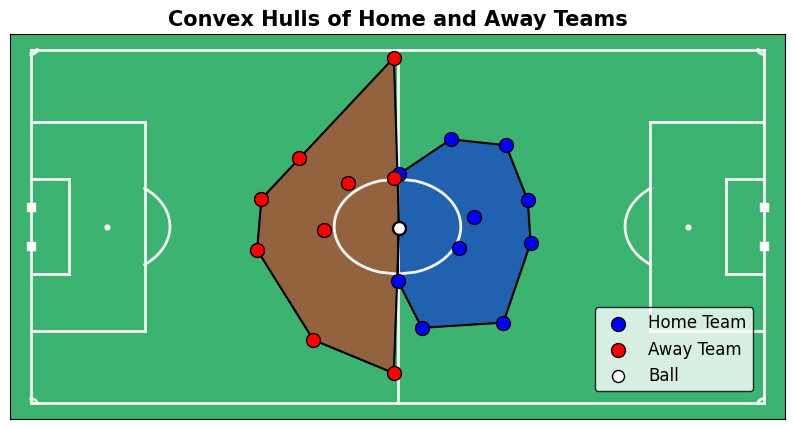

In [20]:
from utils.PlotPitch import PlotPitch
#--------------------------------------------------------------------
# Retrieve the data for the frame
home_data=home_xy.iloc[0,:]
away_data=away_xy.iloc[0,:]
# Exclude players in the bench
home_data=home_data.dropna()
away_data=away_data.dropna()
ball=np.array(home_data[-2:])
home_data= home_data[4:-2] #exclude both the goalkeeper and the ball
away_data= away_data[4:-2] #exclude both the goalkeeper and the ball
#--------------------------------------------------------------------
# divide x and y
home_data_x=home_data[home_data.index.str.contains('_x')]
home_data_y=home_data[home_data.index.str.contains('_y')]
away_data_x=away_data[away_data.index.str.contains('_x')]
away_data_y=away_data[away_data.index.str.contains('_y')]
#--------------------------------------------------------------------
# Coordinates
home_pts= np.array([[x,y] for x,y in zip(home_data_x,home_data_y)])
away_pts= np.array([[x,y] for x,y in zip(away_data_x,away_data_y)])
#--------------------------------------------------------------------
plot=PlotPitch(home_pts=home_pts, away_pts=away_pts, ball=ball,plotHulls=True,plotAllPlayers=True,fig_size=(10,5))
plot
#plot.savefig('plots/convex_hulls_kickoff_matchday2.png',dpi=350,bbox_inches='tight')

Code to make a gif for a range of frames:

In [ ]:
# # Plotting the convex hulls for all frames from 1000 to 1200
# for frame in range(0,2101):
#     #--------------------------------------------------------------------
#     # Retrieve the data for the frame
#     home_data=home_xy.iloc[frame,:]
#     away_data=away_xy.iloc[frame,:]
#     home_data=home_data.dropna()
#     away_data=away_data.dropna()
#     ball=np.array(home_data[-2:])
#     home_data= home_data[4:-2] #exclude both the goalkeeper and the ball
#     away_data= away_data[4:-2] #exclude both the goalkeeper and the ball
#     #--------------------------------------------------------------------
#     # divide x and y
#     home_data_x=home_data[home_data.index.str.contains('_x')]
#     home_data_y=home_data[home_data.index.str.contains('_y')]
#     away_data_x=away_data[away_data.index.str.contains('_x')]
#     away_data_y=away_data[away_data.index.str.contains('_y')]
#     #--------------------------------------------------------------------
#     # Coordinates
#     home_pts= np.array([[x,y] for x,y in zip(home_data_x,home_data_y)])
#     away_pts= np.array([[x,y] for x,y in zip(away_data_x,away_data_y)])
#     #--------------------------------------------------------------------
#     curr_plot=PlotPitch(home_pts=home_pts, away_pts=away_pts, ball=ball,plotHulls=True,plotAllPlayers=True)
#     #save it
#     curr_plot.savefig(f'figs/convex_hulls_{frame}.png', dpi=300, bbox_inches='tight')

#------

# From
# import glob
# from PIL import Image
# from IPython.display import Image as IPImage
# from IPython.display import display

# # Load all the saved images
# image_files = sorted(glob.glob('figs/convex_hulls_*.png'), key=lambda x: int(x.split('_')[-1].split('.')[0]))[49:200]

# # Create a list of images
# # Desired GIF dimensions
# gif_width = 1200
# gif_height = 700
# images = [Image.open(image).resize((gif_width, gif_height), Image.Resampling.LANCZOS) for image in image_files]

# # Save as a GIF
# gif_path = 'gifs/convex_hulls.gif'
# images[0].save(gif_path, save_all=True, append_images=images, duration=0.0001, loop=0)

#display(IPImage(filename=gif_path))

We can now inspect how the hulls change frame by frame

In [48]:
hulls_df= pd.read_csv('data/hulls_df_matchday2.csv')

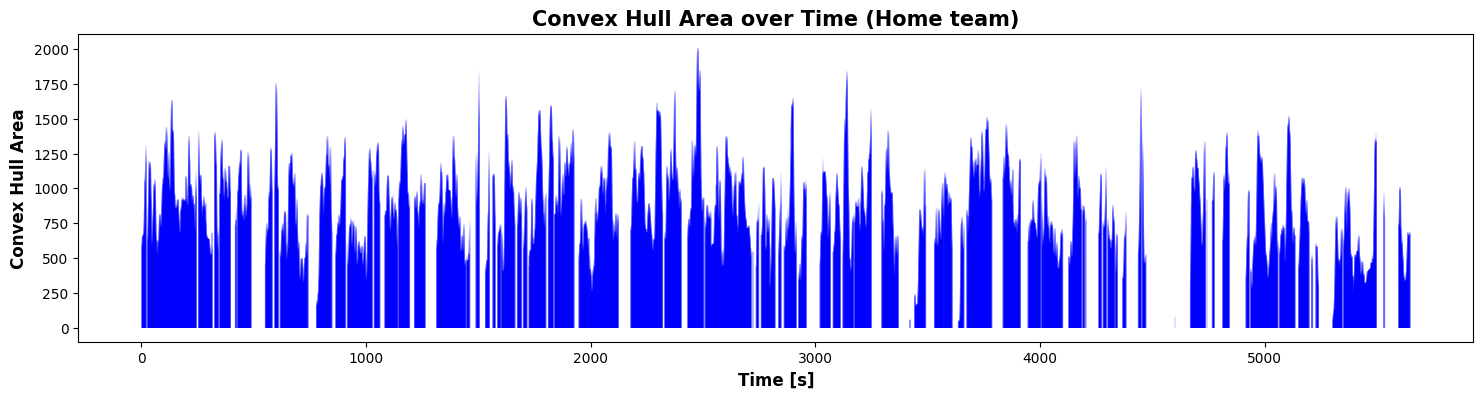

In [25]:
plt.figure(figsize=(18, 4))
plt.vlines(hulls_df["Time [s]"], ymin=0, ymax=hulls_df["HomeHull"], color='blue', linewidth=0.01)
plt.xlabel("Time [s]", fontsize=12, fontweight='bold');
plt.ylabel("Convex Hull Area", fontsize=12, fontweight='bold');
plt.title("Convex Hull Area over Time (Home team)", fontsize=15, fontweight='bold');
plt.savefig("plots/ConvexHull_Home_matchday2.png", dpi=350, bbox_inches='tight')

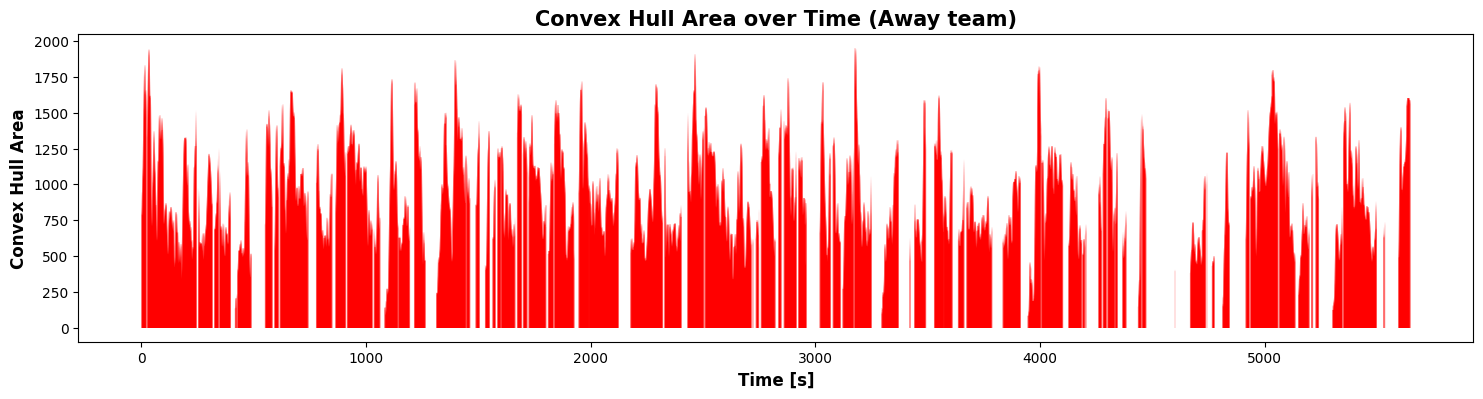

In [27]:
plt.figure(figsize=(18, 4))
plt.vlines(hulls_df["Time [s]"], ymin=0, ymax=hulls_df["AwayHull"], color='red', linewidth=0.01)
plt.xlabel("Time [s]", fontsize=12, fontweight='bold');
plt.ylabel("Convex Hull Area", fontsize=12, fontweight='bold');
plt.title("Convex Hull Area over Time (Away team)", fontsize=15, fontweight='bold');
plt.savefig("plots/ConvexHull_Away_matchday2.png", dpi=350, bbox_inches='tight')

In [28]:
goals_info=events[events["Subtype"].isin(["ON TARGET-GOAL","HEAD-ON TARGET-GOAL","WOODWORK-GOAL"])]
home_goals=goals_info[goals_info["Team"]=="Home"]
away_goals=goals_info[goals_info["Team"]=="Away"]

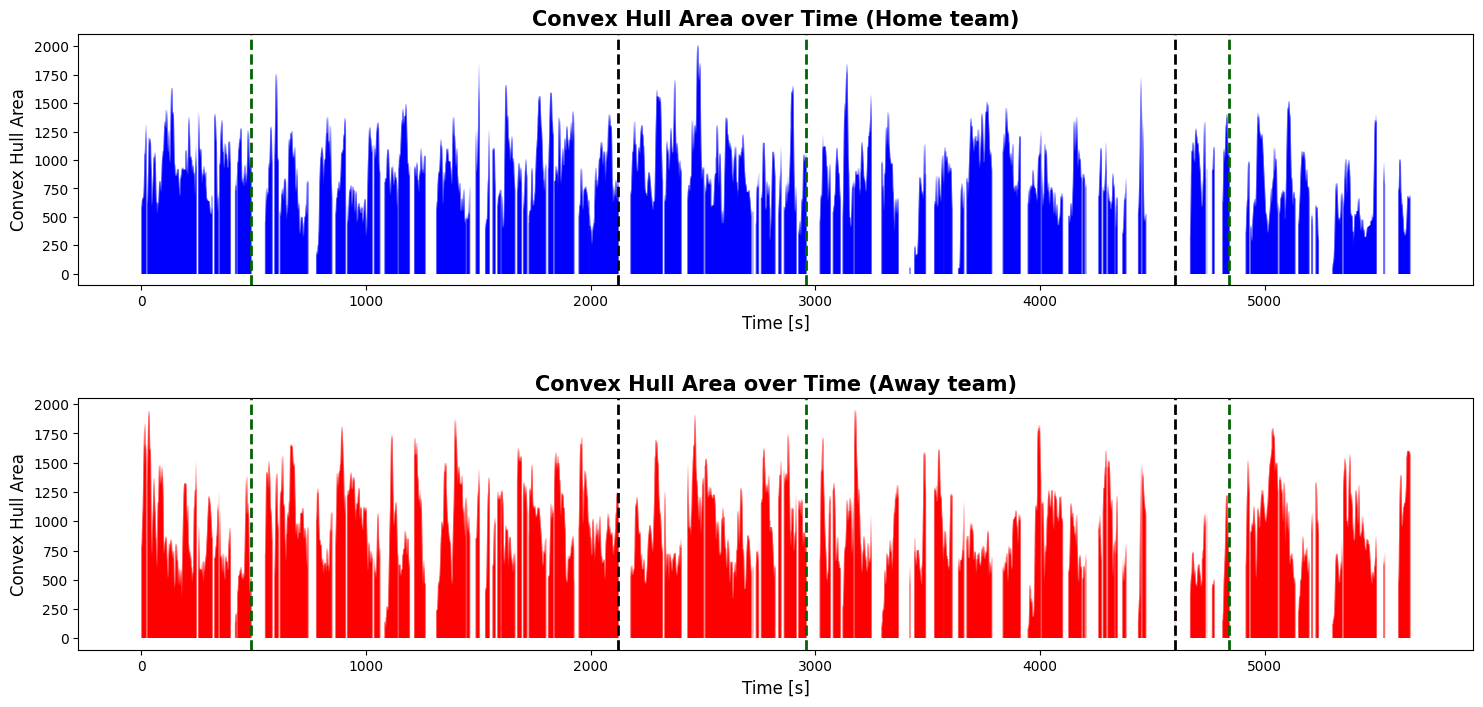

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(18, 8))
# Home team's convex hull area
axs[0].vlines(hulls_df["Time [s]"], ymin=0, ymax=hulls_df["HomeHull"], color='blue', linewidth=0.01)
axs[0].set_xlabel("Time [s]", fontsize=12,fontweight='normal');
axs[0].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[0].set_title("Convex Hull Area over Time (Home team)", fontsize=15, fontweight='bold');

# Away team's convex hull area
axs[1].vlines(hulls_df["Time [s]"], ymin=0, ymax=hulls_df["AwayHull"], color='red', linewidth=0.01)
axs[1].set_xlabel("Time [s]", fontsize=12,fontweight='normal');
axs[1].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[1].set_title("Convex Hull Area over Time (Away team)", fontsize=15, fontweight='bold');

# add vertical lines for home goals
for t1,t2 in zip(home_goals["Start Time [s]"],home_goals["End Time [s]"]):
    axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=2) 
    axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=2)
# add vertical lines for away goals
for t1,t2 in zip(away_goals["Start Time [s]"],away_goals["End Time [s]"]):
    axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=2) 
    axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=2)
# Manage space between subplots
plt.subplots_adjust(hspace=0.45)
plt.savefig("plots/ConvexHull_with_goals_matchday2.png", dpi=350, bbox_inches='tight')

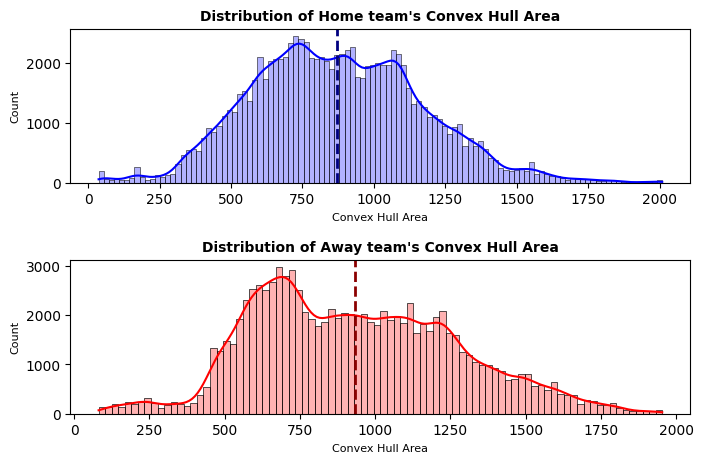

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
sns.histplot(hulls_df["HomeHull"], kde=True, color='blue',alpha=0.3,ax=axs[0])
axs[0].axvline(hulls_df["HomeHull"].mean(), color='navy', linestyle='--', linewidth=2)
axs[0].set_xlabel("Convex Hull Area", fontsize=8, fontweight='normal');
axs[0].set_ylabel("Count", fontsize=8, fontweight='normal');
axs[0].set_title("Distribution of Home team's Convex Hull Area", fontsize=10, fontweight='bold');
sns.histplot(hulls_df["AwayHull"], kde=True, color='red',alpha=0.3,ax=axs[1])
axs[1].axvline(hulls_df["AwayHull"].mean(), color='darkred', linestyle='--', linewidth=2)
axs[1].set_xlabel("Convex Hull Area", fontsize=8, fontweight='normal');
axs[1].set_ylabel("Count", fontsize=8, fontweight='normal');
axs[1].set_title("Distribution of Away team's Convex Hull Area", fontsize=10, fontweight='bold');
plt.subplots_adjust(hspace=0.5)
plt.savefig("plots/ConvexHull_Distribution_matchday2.png", dpi=350, bbox_inches='tight')

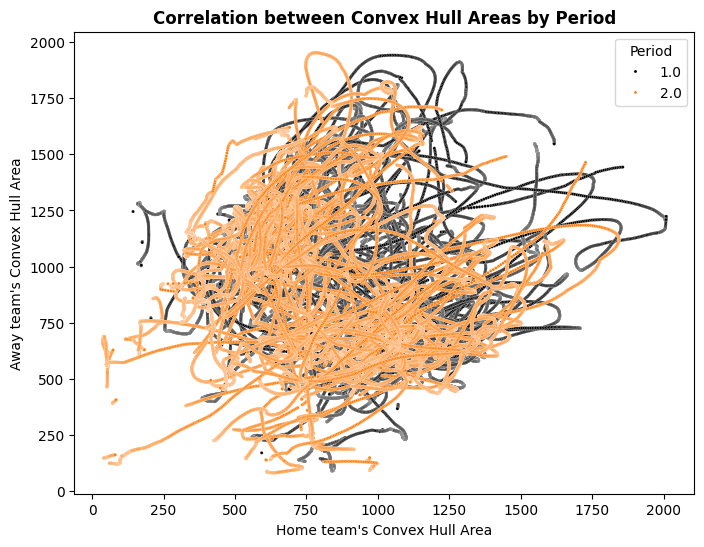

In [32]:
custom_palette = ["black", "#ff7f0e"]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=hulls_df, x="HomeHull", y="AwayHull", hue="Period", palette=custom_palette, s=5)
plt.xlabel("Home team's Convex Hull Area", fontsize=10, fontweight='normal');
plt.ylabel("Away team's Convex Hull Area", fontsize=10, fontweight='normal');
plt.title("Correlation between Convex Hull Areas by Period", fontsize=12, fontweight='bold');
plt.savefig("plots/ConvexHulls_correlation_matchday2.png", dpi=350, bbox_inches='tight')

# Reduce time dimensionality

In [49]:
hulls_df.head()

,Period,Frame,Time [s],HomeHull,AwayHull
0,1.0,0.0,2.00,545.066253,782.194820
1,1.0,1.0,2.04,580.876874,782.477901
2,1.0,2.0,2.08,581.116770,782.804969
3,1.0,3.0,2.12,581.348315,783.177048
4,1.0,4.0,2.16,581.702889,783.361684


In [50]:
hulls_df["Time [s]"]=np.floor(hulls_df["Time [s]"])

In [53]:
# now group by time and summarize HomeHull and AwayHull with mean
hulls_df_compact=hulls_df.loc[:,["Period","Time [s]","HomeHull","AwayHull"]].groupby("Time [s]").mean().reset_index()
#hulls_df_compact.to_csv("data/hulls_df_compact_matchday2_mean.csv",index=False)
hulls_df_compact.head()

,Time [s],Period,HomeHull,AwayHull
0,2.0,1.0,584.492054,789.046673
1,3.0,1.0,610.435976,831.996092
2,4.0,1.0,642.984305,917.031595
3,5.0,1.0,651.063432,972.127810
4,6.0,1.0,667.510469,1036.001978


In [57]:
# now i want to compact every two lines witht he mean
hulls_every2= pd.DataFrame(columns=['Time [s]','Period','HomeHull','AwayHull'])
for row in range(0,hulls_df_compact.shape[0],2):
    time= hulls_df_compact.loc[row,"Time [s]"]
    period= hulls_df_compact.loc[row,"Period"]
    home= hulls_df_compact.loc[row:row+1,"HomeHull"].mean()
    away= hulls_df_compact.loc[row:row+1,"AwayHull"].mean()
    hulls_every2.loc[row]=[time,period,home,away]


In [58]:
hulls_every2.head()

,Time [s],Period,HomeHull,AwayHull
0,2.0,1.0,597.464015,810.521383
2,4.0,1.0,647.023869,944.579702
4,6.0,1.0,668.716043,1061.570185
6,8.0,1.0,657.826932,1236.516611
8,10.0,1.0,684.343047,1470.159649


In [61]:
hulls_every2.to_csv("data/hulls_every2_matchday2.csv",index=False)

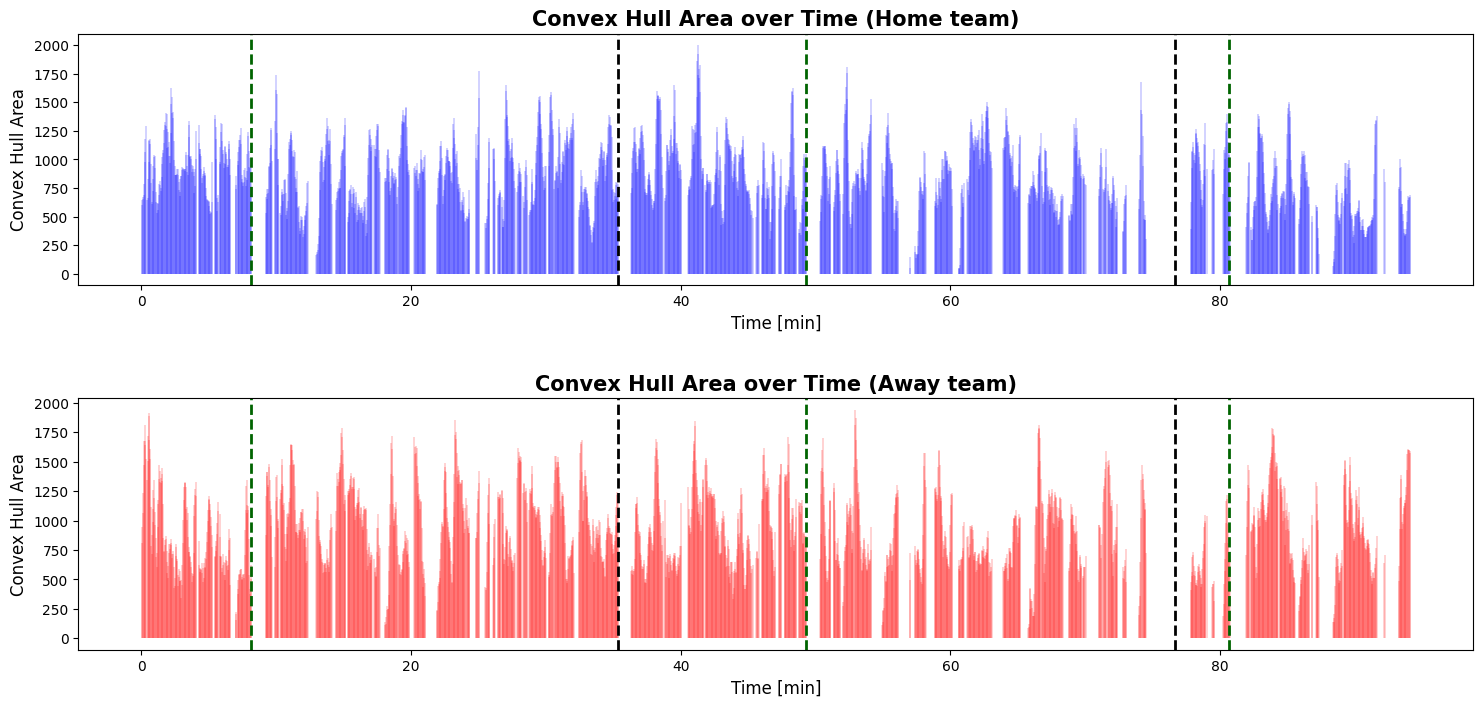

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(18, 8))
# Home team's convex hull area
axs[0].vlines(hulls_every2["Time [s]"]/60, ymin=0, ymax=hulls_every2["HomeHull"], color='blue', linewidth=0.25)
axs[0].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[0].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[0].set_title("Convex Hull Area over Time (Home team)", fontsize=15, fontweight='bold');

# Away team's convex hull area
axs[1].vlines(hulls_every2["Time [s]"]/60, ymin=0, ymax=hulls_every2["AwayHull"], color='red', linewidth=0.25)
axs[1].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[1].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[1].set_title("Convex Hull Area over Time (Away team)", fontsize=15, fontweight='bold');

# add vertical lines for home goals
for t1,t2 in zip(home_goals["Start Time [s]"]/60,home_goals["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=2) 
    axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=2)
# add vertical lines for away goals
for t1,t2 in zip(away_goals["Start Time [s]"]/60,away_goals["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=2) 
    axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=2)
# Manage space between subplots
plt.subplots_adjust(hspace=0.45)
#plt.savefig("plots/ConvexHull_with_goals_matchday2_mean.png", dpi=350, bbox_inches='tight')